In [1]:
# !pip install langchain_community pandas chromadb onnxruntime
# !pip install -U langchain-google-genai
# !pip install --quiet -U langgraph

## Dataset Preparation 

In [2]:
import pandas as pd

In [3]:
df_qa = pd.read_csv('qa.csv')
df_qa.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [4]:
df_qa.columns

Index(['qtype', 'Question', 'Answer'], dtype='object')

In [5]:
len(df_qa)

16407

In [6]:
df_qa=df_qa.sample(500, random_state=0).reset_index(drop=True)

In [7]:
df_qa["combined_text"] = (
    "Question:" + df_qa["Question"].astype(str) + ". "+
    "Answer:" + df_qa["Answer"].astype(str) + ". " +
    "Type:" + df_qa["qtype"].astype(str) + ". " 
)

df_qa.head()

,qtype,Question,Answer,combined_text
0,frequency,How many people are affected by X-linked chond...,The prevalence of X-linked chondrodysplasia pu...,Question:How many people are affected by X-lin...
1,treatment,What are the treatments for Kawasaki disease ?,These resources address the diagnosis or manag...,Question:What are the treatments for Kawasaki ...
2,genetic changes,What are the genetic changes related to Ellis-...,Ellis-van Creveld syndrome can be caused by mu...,Question:What are the genetic changes related ...
3,symptoms,What are the symptoms of Renal dysplasia-limb ...,What are the signs and symptoms of Renal dyspl...,Question:What are the symptoms of Renal dyspla...
4,information,What is (are) Fraser syndrome ?,Fraser syndrome is a rare disorder that affect...,Question:What is (are) Fraser syndrome ?. Answ...


In [8]:
text = df_qa["combined_text"][:2]
text.tolist()

['Question:How many people are affected by X-linked chondrodysplasia punctata 1 ?. Answer:The prevalence of X-linked chondrodysplasia punctata 1 is unknown. Several dozen affected males have been reported in the scientific literature.. Type:frequency. ',
 "Question:What are the treatments for Kawasaki disease ?. Answer:These resources address the diagnosis or management of Kawasaki disease:  - Cincinnati Children's Hospital Medical Center  - Genetic Testing Registry: Acute febrile mucocutaneous lymph node syndrome  - National Heart, Lung, and Blood Institute: How is Kawasaki Disease Treated?   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type:treatment. "]

In [9]:
df_medical_Device=pd.read_csv("medical_device_manuals_dataset.csv")
df_medical_Device.head()

,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C
0,Insulin Pump,DAN246,Danaher,2023-05-C,2022-01-27,Class I,NDA412861,Adult and Pediatric,Indicated for real-time heart rate assessment ...,Not recommended for use in radiation therapy p...,NaN,11,11,5.0,7.85,12.0
1,Ventilator,Model 4428,Fresenius Medical Care,v8.4,2015-11-01,Class II,IDE380253,Adult,Intended for infection control evaluation in r...,Not recommended in presence of pulmonary edema...,Single-Use Sterile,25,13,8.0,69.53,26.0
2,Surgical Robot,ABB102,Abbott,Version 10,2015-12-03,Class I,H394827,Pediatric,Intended for infection control therapy in inte...,Not recommended for use in burn patients or th...,Hydrogen Peroxide Plasma,14,28,8.0,10.61,39.0
3,Blood Pressure Monitor,Plus269,Dentsply Sirona,Rev. 8.7,2020-03-18,Class III,NDA972045,Adult and Pediatric,Indicated for emergency pulmonary function sta...,Not recommended for patients with autoimmune d...,Pre-Sterilized,7,20,9.0,7.64,30.0
4,Pulse Oximeter,SYN478,Synthes,Rev. 10.9,2016-08-28,Class IIa,PMDA-850639,All,Used for emergency joint replacement in acute ...,Contraindicated in patients with thrombocytope...,Ethylene Oxide (EtO),3,4,7.0,0.32,35.0


In [10]:
df_medical_Device=df_medical_Device.sample(500, random_state=0).reset_index(drop=True)
df_medical_Device.head()

,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C
0,Electrosurgical Unit,Model 1606,Zimmer Biomet,2023-04-Z,2018-04-28,Class IIb,MDR-847127,All,Used for thermal therapy guidance in oncology ...,Contraindicated in presence of radio frequenci...,Hydrogen Peroxide Plasma,10,15,15.0,6.71,27.0
1,Dialysis Machine,X-6538,3M Healthcare,v2.8,2018-04-03,Class I,MDR-416480,Adult (>65),Used for post-operative chemotherapy managemen...,NaN,Gamma Irradiation,8,11,11.0,NaN,17.0
2,Ventilator,SON230,Sonova,Version 13,2022-02-24,Class III,BLA670706,Adult (>65),Indicated for real-time temperature assessment...,Do not use during general anesthesia administr...,Pre-Sterilized,18,28,11.0,149.42,25.0
3,Dialysis Machine,Max787,Boston Scientific,v4.7,2016-05-08,Class II,BLA131698,Neonatal,Intended for sterilization guidance during min...,"Not recommended during pregnancy, lactation, o...",NaN,10,15,15.0,20.96,20.0
4,Electrosurgical Unit,Plus691,Abbott,2020-03-Q,2015-01-30,Class III,H127393,Pediatric,Intended for life support evaluation in rehabi...,Contraindicated in patients with severe diabet...,Single-Use Sterile,13,17,8.0,7.75,31.0


In [11]:
df_medical_Device["combined_text"] = (
    "Device Name:" + df_medical_Device["Device_Name"].astype(str) + ". "+
    "Model:" + df_medical_Device["Model_Number"].astype(str) + ". "+
    "Manufacturer:" + df_medical_Device["Manufacturer"].astype(str) + ". "+
    "Indications_for_Use:" + df_medical_Device["Indications_for_Use"].astype(str) + ". "+
    "Contraindications: " + df_medical_Device["Contraindications"].astype(str) + ". "
)

In [12]:
df_medical_Device[:2]

,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C,combined_text
0,Electrosurgical Unit,Model 1606,Zimmer Biomet,2023-04-Z,2018-04-28,Class IIb,MDR-847127,All,Used for thermal therapy guidance in oncology ...,Contraindicated in presence of radio frequenci...,Hydrogen Peroxide Plasma,10,15,15.0,6.71,27.0,Device Name:Electrosurgical Unit. Model:Model ...
1,Dialysis Machine,X-6538,3M Healthcare,v2.8,2018-04-03,Class I,MDR-416480,Adult (>65),Used for post-operative chemotherapy managemen...,NaN,Gamma Irradiation,8,11,11.0,NaN,17.0,Device Name:Dialysis Machine. Model:X-6538. Ma...


In [13]:
import chromadb

In [14]:
client= chromadb.PersistentClient(path="./chroma_db")

In [15]:
collection1=client.get_or_create_collection(name="medical_q_n_a")

In [16]:
collection1.add(
    documents=df_qa["combined_text"].tolist(),
    metadatas=df_qa.to_dict(orient="records"),
    ids=df_qa.index.astype(str).tolist()
)

In [17]:
query="What are the treatments for Kawasaki disease ?"

In [18]:
results=collection1.query(
    query_texts=[query],
    n_results=3
)
results

{'ids': [['1', '393', '60']],
 'embeddings': None,
 'documents': [["Question:What are the treatments for Kawasaki disease ?. Answer:These resources address the diagnosis or management of Kawasaki disease:  - Cincinnati Children's Hospital Medical Center  - Genetic Testing Registry: Acute febrile mucocutaneous lymph node syndrome  - National Heart, Lung, and Blood Institute: How is Kawasaki Disease Treated?   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type:treatment. ",
   'Question:What are the treatments for Krabbe Disease ?. Answer:There is no cure for Krabbe disease. Results of a very small clinical trial of children with infantile Krabbe disease found that children who received umbilical cord blood stem cells from unrelated donors prior to symptom onset developed with little neurological impairment. Bon

In [19]:
collection2 = client.get_or_create_collection(
    name="medical_device_manuals",
)

In [ ]:
collection2.add(
    documents=df_medical_Device["combined_text"].tolist(),
    metadatas=df_medical_Device.to_dict(orient="records"),
    ids=df_medical_Device.index.astype(str).tolist()
)

In [21]:
query = "Which devices are suitable for neonatal patients ?"

In [22]:
results=collection2.query(query_texts=[query], n_results=3)

In [23]:
results

{'ids': [['218', '429', '67']],
 'embeddings': None,
 'documents': [['Device Name:Pacemaker. Model:JOH663. Manufacturer:Johnson & Johnson. Indications_for_Use:Designed for catheterization support in neonatal intensive care environments.. Contraindications: Avoid use in patients with cardiac devices or cochlear implants. Not suitable for chemical exposure areas.. ',
   'Device Name:CPAP Machine. Model:B. 401. Manufacturer:B. Braun. Indications_for_Use:Designed for surgical intervention support in neonatal intensive care environments.. Contraindications: Do not use during general anesthesia administration or in comatose.. ',
   'Device Name:Orthopedic Implant. Model:PHI214. Manufacturer:Philips Healthcare. Indications_for_Use:Designed for defibrillation support in neonatal intensive care environments.. Contraindications: Do not use if patient has known allergy to latex proteins or hypersensitivity to cleaning solvents.. ']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distanc

## Setting wesearch api: serperAPI

2500 free 

In [24]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from dotenv import load_dotenv
load_dotenv()
import os
SERPER_API_KEY=os.getenv("SERPER_API_KEY")
serper_api = GoogleSerperAPIWrapper(serper_api_key=SERPER_API_KEY)
serper_api.run(query="What is disease ?")

"A disease is a particular abnormal condition that adversely affects the structure or function of all or part of an organism Disease is any harmful deviation from the normal structural or functional state of an organism. It generally is associated with certain ... An abnormal condition that affects the structure or function of part or all of the body and is usually associated with specific signs and symptoms. 1. a condition of the living animal or plant body or of one of its parts that impairs normal functioning and is typically manifested by distinguishing signs ... A disease is a disorder that interferes with your body's normal functions. “Typically, a disease is something that your physician diagnoses. Disease can be defined as to be a lack of health with both physical and mental symptoms that cause a functioning outside the normal range of accepted values. The answer to “What is a disease?” is straightforward. Most of us feel we have an intuitive grasp of the idea, reaching mentall

### Setting up model

In [25]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI
def get_llm_response(prompt: str) -> str:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        top_p=0.95,
    )
    response = llm.invoke([("user", prompt)])
    return response.content

c:\Users\laksh\OneDrive\Desktop\learning\lenv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [27]:
get_llm_response("Explain the theory of relativity in simple terms.")

'The theory of relativity, developed by Albert Einstein, isn\'t just one idea, but two interconnected theories: **Special Relativity** (1905) and **General Relativity** (1915).\n\nAt its heart, relativity tells us that **space and time are not absolute and fixed backdrops** against which events happen. Instead, they are dynamic and interconnected, influenced by motion and gravity.\n\nLet\'s break it down simply:\n\n---\n\n### 1. The "Relative" Part: Frames of Reference\n\nImagine you\'re on a train moving at a constant speed.\n*   If you walk down the aisle, your speed relative to the train is, say, 3 mph.\n*   But to someone standing on the ground watching the train go by, your speed is 3 mph *plus* the speed of the train.\n\nThis is a "frame of reference." What you observe depends on your own motion. This idea isn\'t new, but Einstein took it to a revolutionary level.\n\n---\n\n### 2. Special Relativity (SR): The Rules for Constant Motion\n\nSpecial Relativity deals with objects movi

### Traditional RAG for collection 1

Query -> Retrieve -> Prompt Building(Augment)-> Generate
 

In [28]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

In [29]:
class GraphState(TypedDict):
    query: str
    prompt: str
    context: str
    response: str

In [30]:
def retrieve_context(state):
    """Retrieve relevant context from the vector database based on the query."""
    print("Retrieving context for query:", state["query"])
    query = state["query"]
    results=collection1.query(
        query_texts=[query],
        n_results=3
    )
    context_retrieved="\n".join(results['documents'][0])
    state["context"] = context_retrieved
    print("Context retrieved:\n", state["context"])
    return state

In [31]:
def build_prompt(state):
    """Construct a rag style prompt using the retrieved context and the original query."""
    print("Building prompt.")
    query=state["query"]
    context=state["context"]
    prompt=f"""
    Answer the question based on the context below.
    Context: {context}
    Question: {query}
    Please limit the answer in 50 words.
    """
    state["prompt"] = prompt
    print("Prompt built:\n", state["prompt"])
    return state

In [32]:
def generate_response(state):
    """
    Based on the query along with context, give a response
    """
    prompt=state["prompt"]
    response=get_llm_response(prompt)
    state["response"]=response
    return state

In [33]:
workflow = StateGraph(GraphState)
workflow.add_node("Retrieve", retrieve_context)
workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", generate_response)
workflow.add_edge(START, "Retrieve")
workflow.add_edge("Retrieve", "Augment")
workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)

In [34]:
rag_agent=workflow.compile()

In [35]:
input_state = {"query": "What are the treatments for Kawasaki disease ?"}
from pprint import pprint
for step in rag_agent.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}")
pprint(value["response"])

Retrieving context for query: What are the treatments for Kawasaki disease ?
Context retrieved:
 Question:What are the treatments for Kawasaki disease ?. Answer:These resources address the diagnosis or management of Kawasaki disease:  - Cincinnati Children's Hospital Medical Center  - Genetic Testing Registry: Acute febrile mucocutaneous lymph node syndrome  - National Heart, Lung, and Blood Institute: How is Kawasaki Disease Treated?   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type:treatment. 
Question:What are the treatments for Krabbe Disease ?. Answer:There is no cure for Krabbe disease. Results of a very small clinical trial of children with infantile Krabbe disease found that children who received umbilical cord blood stem cells from unrelated donors prior to symptom onset developed with little neuro

traditional rag follows 'retrive and generate' paradigm - just grabs info from a set sources and answers based on that	
- retreives semantically similar but contextually irrelevant info	
- misses multi-hop reasoning and deep contextual understanding	
- scalability issues as knowledge base grows: context window limits and high computational overhead	
- lacks dynamic retrieval: cannot adapt to new info or changing user intents or feedback or evolving contexts	


### Asking an out of syllabus question

In [36]:
input_state = {"query": "What are the treatments for Huntington's disease ?"}
from pprint import pprint
for step in rag_agent.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}")
pprint(value["response"])

Retrieving context for query: What are the treatments for Huntington's disease ?
Context retrieved:
 Question:What are the treatments for Sotos syndrome ?. Answer:These resources address the diagnosis or management of Sotos syndrome:  - Gene Review: Gene Review: Sotos Syndrome  - Genetic Testing Registry: Sotos' syndrome  - MedlinePlus Encyclopedia: Increased Head Circumference   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type:treatment. 
Question:What are the treatments for Alstrm syndrome ?. Answer:These resources address the diagnosis or management of Alstrm syndrome:  - Gene Review: Gene Review: Alstrom Syndrome  - Genetic Testing Registry: Alstrom syndrome  - MedlinePlus Encyclopedia: Acanthosis Nigricans  - MedlinePlus Encyclopedia: Alstrm syndrome   These resources from MedlinePlus offer information 

Here the system clearly fails. 
So we can use Agentic RAG as saviour.

### Agentic RAG

 Uses autonomous agents that actively decide what to reteive, how , when and from which sources like web, vector dbs.

Core idea: introducing a routing agent that decides among multiple retrieval options and then validates the retrieved context for relevance.

Query -> router (source selection) -> retrieval -> relevance checker-> if relevant: generate, if not relevant:Go to websearch -> End

Key nodes:
- Router node: constructs a decision making prompt from which llm will return the most relvant source of info
- Retriever nodes: if there are n different sources, there will be n retriever nodes which will return some context string and sets a 'source' label
- Relevance checker: asks llm if the retrieved context is relevant- ys or no
- conditional routing:  if _yes_ -> prompt building -> llm response
                          => _no_ -> fall back to web search (any default source) and re-run the relevance check
                        : the flow limits iteration to max of 3


In [37]:
def retrieve_context_device(state):
    """Retrieve relevant context from the device vector database based on the query."""
    print("Retrieving context for query:", state["query"])
    query = state["query"]
    results=collection2.query(
        query_texts=[query],
        n_results=3
    )
    context_retrieved="\n".join(results['documents'][0])
    state["context"] = context_retrieved
    state["source"] = "Medical Device Manual"
    print("Context retrieved:\n", state["context"])
    return state

In [38]:
def retrieve_context_qna(state):
    """Retrieve relevant context from the qna vector database based on the query."""
    print("Retrieving context for query:", state["query"])
    query = state["query"]
    results=collection1.query(
        query_texts=[query],
        n_results=3
    )
    context_retrieved="\n".join(results['documents'][0])
    state["context"] = context_retrieved
    state["source"] = "Medical Q&A Collection"

    print("Context retrieved:\n", state["context"])
    return state

In [39]:
def retrieve_context_websearch(state):
    """Retrieve relevant context from websearch based on the query."""
    print("Retrieving context for query:", state["query"])
    query = state["query"]
    serper_api = GoogleSerperAPIWrapper(serper_api_key=SERPER_API_KEY)
    web_result=serper_api.run(query=query)
    state["context"] = web_result
    state["source"] = "Web Search"

    return state

In [40]:
def router(state: GraphState):
    query=state["query"]
    prompt=f"""
    You are a routing agent. Based on the given user query, decide where to look for information.
    Options:
        - Retrieve_from_QnA: If its about general medical knowledge, symptoms, or treatments 
        - Retrieve_from_Device: if its about medical devices, manuals or instructions. 
        - Web_Search: if its about recent news, brand names, or external data.
    Query: {query}
    Respond only with one of : Retrieve_from_QnA, Retrieve_from_Device, Web_Search
    """
    response = get_llm_response(prompt).strip()
    state["source"]=response
    return state

In [53]:
def routing_decision(state: GraphState):
    print(state)
    return state["source"]

In [54]:
def build_prompt(state):
    """Construct a rag style prompt using the retrieved context and the original query."""
    print("Building prompt.")
    query=state["query"]
    context=state["context"]
    prompt=f"""
    Answer the question based on the context below.
    Context: {context}
    Question: {query}
    Please limit the answer in 50 words.
    """
    state["prompt"] = prompt
    print("Prompt built:\n", state["prompt"])
    return state

In [55]:
def generate_response(state):
    """
    Based on the query along with context, give a response
    """
    prompt=state["prompt"]
    response=get_llm_response(prompt)
    state["response"]=response
    return state

In [63]:
def check_context_relevance(state):
    query=state["query"]
    context=state["context"]
    relevance_prompt=f"""
    Check the below context and if the context is relevant to the user query, answer with "Yes" or "No" accordingly.
    ####
    Context:
    {context}
    #####

    User Query: {query}
    Options:
        - Yes: If the context is relevant
        - No: If the context is not relevant

    Please answer with only 'Yes' or 'No'
    """
    response=get_llm_response(relevance_prompt).strip()
    state["is_relevant"] = response
    print(f"---RELEVANCE CHECKED: {response}----")
    return state

In [64]:
def relevance_decision(state: GraphState):
    iteration_count=state.get("iteration_count", 0)
    iteration_count+=1
    state["iteration_count"]=iteration_count
    if iteration_count>3:
        state["is_relevant"]="Yes"
    return state["is_relevant"]

In [65]:
class GraphState(TypedDict):
    query: str
    prompt: str
    context: str
    response: str
    source: str
    is_relevant: str
    iteration_count: str

In [66]:
workflow = StateGraph(GraphState)

workflow.add_node("Router", router)
workflow.add_node("Retrieve_from_QnA", retrieve_context_qna)
workflow.add_node("Retrieve_from_Device", retrieve_context_device)
workflow.add_node("Web_Search", retrieve_context_websearch)
workflow.add_node("Relevance_Checker", check_context_relevance)

workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", generate_response)

workflow.add_edge(START, "Router")
workflow.add_conditional_edges(
    "Router",
    routing_decision,
    {
        "Retrieve_from_QnA":"Retrieve_from_QnA",
        "Retrieve_from_Device":"Retrieve_from_Device",
        "Web_Search":"Web_Search"

    }

)
workflow.add_edge("Retrieve_from_QnA", "Relevance_Checker")
workflow.add_edge("Retrieve_from_Device", "Relevance_Checker")
workflow.add_edge("Web_Search", "Relevance_Checker")

workflow.add_conditional_edges(
    "Relevance_Checker",
    relevance_decision,
    {
        "Yes":"Augment",
        "No":"Web_Search",

    }
)

workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)

In [67]:
agentic_rag=workflow.compile()

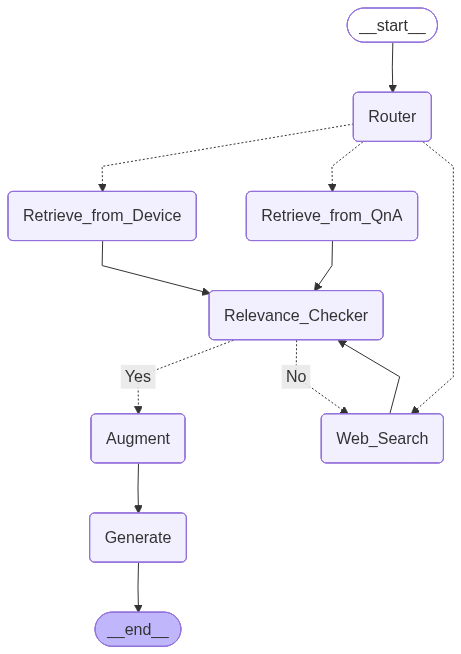

In [68]:
from IPython.display import Image, display
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

### Asking the same out of syllabus question

In [ ]:
input_state = {"query": "What are the treatments for Huntington's disease ?"}
from pprint import pprint
for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}")

{'query': "What are the treatments for Huntington's disease ?", 'source': 'Retrieve_from_QnA'}
'Finished running: Router'
Retrieving context for query: What are the treatments for Huntington's disease ?
Context retrieved:
 Question:What are the treatments for Sotos syndrome ?. Answer:These resources address the diagnosis or management of Sotos syndrome:  - Gene Review: Gene Review: Sotos Syndrome  - Genetic Testing Registry: Sotos' syndrome  - MedlinePlus Encyclopedia: Increased Head Circumference   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type:treatment. 
Question:What are the treatments for Alstrm syndrome ?. Answer:These resources address the diagnosis or management of Alstrm syndrome:  - Gene Review: Gene Review: Alstrom Syndrome  - Genetic Testing Registry: Alstrom syndrome  - MedlinePlus Encyclopedi

In [ ]:
print(value["response"])

Treatments for Huntington's disease include medications like haloperidol, tetrabenazine, and amantadine to manage movement and mental health symptoms. Rehabilitation therapies (physical, occupational, speech) and exercise also help. A new gene therapy, given via brain surgery, shows promise in slowing disease progression by targeting the toxic huntingtin protein, potentially altering the disease's course. 

_SUCCESS!_